<a href="https://colab.research.google.com/github/rishabhgupta592/CallCenterAudioClassification/blob/main/CallCenterAudioClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split    
from pprint import pprint

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data Exploration

In [ ]:
# label_data = pd.read_csv("./data/metaData/mapping_conv_topic.train.txt", delimiter=" ")
# label_data

In [ ]:
def load_file_content(file):
  sentence = ""
  prev_speaker = ""
  for line in file:
    line = line.replace("[silence]", "")
    line = line.replace("[noise]", "")
    line = line.replace("[", "")
    line = line.replace("]", "")
    splitted_line = line.split()
    line = " ".join(splitted_line[3:])
    speaker = splitted_line[0]
    if line != "":
      if prev_speaker == speaker:
        sentence = sentence + " " + line
      else:
        sentence = sentence + ". " + line
    prev_speaker = speaker
  return sentence

In [ ]:
# files = []
# rawfilename = []
# content = []
# for filename in os.listdir("./data/trainData/"):
#   file = open("./data/trainData/"+filename, "r")
#   file_content = load_file_content(file)
#   files.append(filename)
#   rawfilename.append(filename.split(".")[1])

#   content.append(file_content)

# data = pd.DataFrame(list(zip(files, rawfilename, content, )),
#                columns =['fileNameActual', 'FileName', 'content'])
# data

In [ ]:
# # Getting agent and customer data together with label
# data['FileName'] = data.FileName.astype(int)

# final_df = data.merge(label_data, on=["FileName"])
# final_df.to_csv("prepared_data.csv")

In [ ]:
final_df = pd.read_csv("prepared_data.csv")
final_df

,Unnamed: 0,fileNameActual,FileName,content,Label
0,0,trans.4039.txt,4039,. course i don't like talking about budgets la...,Family Finance
1,1,trans.3786.txt,3786,. -hello okay so you were with TI huh yeah i'v...,Job Benefits
2,2,trans.2348.txt,2348,hi Ellen. hi. um do you uh could you tell me ...,Family Finance
3,3,trans.3409.txt,3409,. so how many um credit cards do you have. um ...,Credit Card
4,4,trans.3675.txt,3675,do you wanna tell me about your budgeting pla...,Family Finance
...,...,...,...,...,...
235,235,trans.4863.txt,4863,. we're supposed to talk about if we agree on ...,Taxes
236,236,trans.2399.txt,2399,okay um let's see how do you feel about laugh...,Credit Card
237,237,trans.4155.txt,4155,. um. what's our topic. taxes do we pay too mu...,Taxes
238,238,trans.2917.txt,2917,hi what do you do with your credit cards. oh ...,Credit Card


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


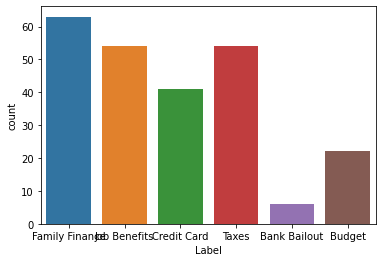

In [ ]:
sns.countplot(final_df['Label'])

In [ ]:
final_df["Label"].value_counts()

Family Finance    63
Job Benefits      54
Taxes             54
Credit Card       41
Budget            22
Bank Bailout       6
Name: Label, dtype: int64

In [ ]:
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X = 
# X, y = oversample.fit_resample(X, y)

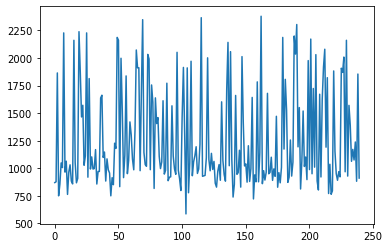

In [ ]:
final_df['word_length'] = final_df.content.apply(lambda i: len(i.split()))
# final_df.plot(kind='scatter',x='num_children',y='num_pets',color='red')
final_df['word_length'].plot(kind='line')
plt.show()


In [ ]:
final_df['word_length'].describe()

count     240.000000
mean     1255.870833
std       444.649149
min       586.000000
25%       930.500000
50%      1057.000000
75%      1599.000000
max      2378.000000
Name: word_length, dtype: float64

In [ ]:
final_df['word_length'].quantile([.1, .25, .5, .75])

0.10     863.6
0.25     930.5
0.50    1057.0
0.75    1599.0
Name: word_length, dtype: float64

# Feature Extraction

In [ ]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
def process(text):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(text))
    
    # remove all single characters
    #text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    processed_text = text.lower()
    # text_list = word_tokenize(processed_text)
    # stemmed_text
    # for word in text_list:
    #     word = ps.stem(word)
    # processed_text = " ".join(text_list)
    return processed_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
final_df['content_processed'] = final_df["content"].progress_apply(process)

In [ ]:
text = np.array(final_df['content_processed'])
category = np.array(final_df['Label']) 
Train_X, Test_X, Train_Y, Test_Y = train_test_split(text, category, test_size=0.2, random_state=101)

In [ ]:
# build TFIDF features on train articles
# tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1),stop_words='english', max_features= 5000,
                    #  sublinear_tf=True)
# tv.fit(text)
from sklearn.feature_extraction.text import CountVectorizer

tv = CountVectorizer(min_df=0, lowercase=False)
tv.fit(text)
Train_X = tv.transform(Train_X)
Test_X  = tv.transform(Test_X)
Train_X

<192x7464 sparse matrix of type '<class 'numpy.int64'>'
	with 65094 stored elements in Compressed Sparse Row format>

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', k_neighbors=4)
Train_X, Train_Y = oversample.fit_resample(Train_X, Train_Y)
# X

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Train_Y.shape


In [ ]:
print('TFIDF model:> Train features shape:', Train_X.shape)
print('TFIDF model:> Test features shape:', Test_X.shape)

TFIDF model:> Train features shape: (238, 7464)
TFIDF model:> Test features shape: (48, 7464)


In [ ]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
print('Train label shape:', Train_Y.shape)
print('Test label shape: ', Test_Y.shape)

Train label shape: (238,)
Test label shape:  (48,)


# ML model Creation

In [ ]:
from keras.models import Sequential
from keras import layers

input_dim = Train_X.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(6, activation='Softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                74650     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 74,716
Trainable params: 74,716
Non-trainable params: 0
_________________________________________________________________


In [ ]:
>>> history = model.fit(Train_X, Train_Y,
...                     epochs=15,
...                     verbose=True,
...                     batch_size=64)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


4/4 [==============================] - 12s 6ms/step - loss: 2.2467 - accuracy: 0.2773
Epoch 2/15
4/4 [==============================] - 0s 5ms/step - loss: 1.3448 - accuracy: 0.4304
Epoch 3/15
4/4 [==============================] - 0s 5ms/step - loss: 1.0717 - accuracy: 0.5950
Epoch 4/15
4/4 [==============================] - 0s 5ms/step - loss: 0.7993 - accuracy: 0.7120
Epoch 5/15
4/4 [==============================] - 0s 5ms/step - loss: 0.5763 - accuracy: 0.8181
Epoch 6/15
4/4 [==============================] - 0s 6ms/step - loss: 0.3810 - accuracy: 0.9333
Epoch 7/15
4/4 [==============================] - 0s 5ms/step - loss: 0.3370 - accuracy: 0.9310
Epoch 8/15
4/4 [==============================] - 0s 5ms/step - loss: 0.2496 - accuracy: 0.9421
Epoch 9/15
4/4 [==============================] - 0s 5ms/step - loss: 0.2064 - accuracy: 0.9437
Epoch 10/15
4/4 [==============================] - 0s 6ms/step - loss: 0.1597 - accuracy: 0.9509
Epoch 11/15
4/4 [==============================] 

In [ ]:
# tf.keras.backend.clear_session()

# Accuracy 

In [ ]:
loss, accuracy = model.evaluate(Train_X, Train_Y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Test_X, Test_Y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9706
Testing Accuracy:  0.8125


In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,auc,roc_auc_score,classification_report
y_score = model.predict_classes(Test_X)
print(y_score.shape)
print("*"*10)
# y_pred_test = clf.predict(tfidf_test_features)
print("Confusion matrix \n", metrics.confusion_matrix(Test_Y, y_score))
cr=classification_report(Test_Y,y_score)
print(cr)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(48,)
**********
Confusion matrix 
 [[ 0  0  0  0  0  1]
 [ 0  0  0  0  2  6]
 [ 0  0  8  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0  9  0]
 [ 0  0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        12
           4       0.82      1.00      0.90         9
           5       0.59      1.00      0.74        10

    accuracy                           0.81        48
   macro avg       0.57      0.67      0.61        48
weighted avg       0.69      0.81      0.74        48



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    # plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    # plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

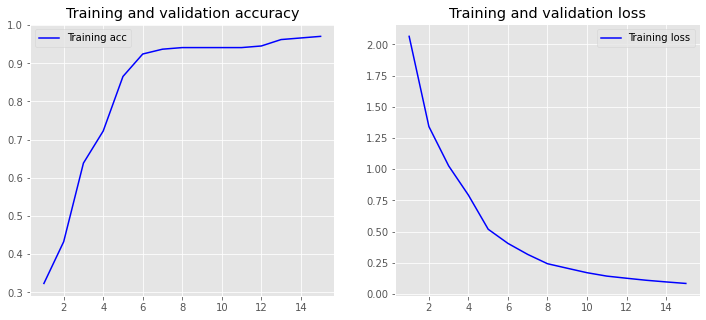

In [ ]:
plot_history(history)

In [ ]:
print("0 = ",Encoder.inverse_transform([0])[0])
print("1 = ",Encoder.inverse_transform([1])[0])
print("2 = ",Encoder.inverse_transform([2])[0])
print("3 = ",Encoder.inverse_transform([3])[0])
print("4 = ",Encoder.inverse_transform([4])[0])
print("5 = ",Encoder.inverse_transform([5])[0])

0 =  Bank Bailout
1 =  Budget
2 =  Credit Card
3 =  Family Finance
4 =  Job Benefits
5 =  Taxes


In [ ]:
# content = {
#     "Train Sample Count": Train_X.shape[0],
#     "Test Sample Count": Test_X.shape[0],
#     "Num of Classes": final_df['Label'].nunique(),
#     "Num of Features": Test_X.shape[1],
#     "kernel": "rbf",
#     "Training Accuracy": "{:.3f}".format(clf.score(train_x_feature, Train_Y)),
#     "Test Accuracy": "{:.3f}".format(clf.score(test_x_feature, Test_Y)),
#     "Precision": "{:.3f}".format(precision),
#     "Recall": "{:.3f}".format(recall)
# }

# import json
# print(json.dumps(content, indent = 1)) 

In [ ]:
def get_prediction(sent):
    sent = process(sent)
    test_vec = tv.transform([sent])
    # SVM.predict(test_vec)

    class_value = model.predict_classes(test_vec)
    # prob = clf.predict_proba(test_vec)[0][class_value[0]]
#     print("Calss_value = ", class_value)
#     print("Predicted Class = ", Encoder.inverse_transform(class_value)[0])
#     print("Probabilty  = ", prob)
    return Encoder.inverse_transform(class_value)[0]

# Model Save

In [ ]:
# model.save('c2v_model')
# import pickle
pickle.dump(Encoder, open("c2v_encoder.pickle", 'wb'))
pickle.dump(tv, open("c2v_count_vector.pickle", 'wb'))

In [ ]:
# Zero Shot experiment

# Other embeddings

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import codecs
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
# Any results you write to the current directory are saved as output.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install wget
import os
import wget
import gzip
import shutil

gn_vec_path = "GoogleNews-vectors-negative300.bin"
if not os.path.exists("GoogleNews-vectors-negative300.bin"):
    if not os.path.exists("../Ch2/GoogleNews-vectors-negative300.bin"):
        #Downloading the reqired model
        if not os.path.exists("../Ch2/GoogleNews-vectors-negative300.bin.gz"):
            if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
                wget.download("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz")
            gn_vec_zip_path = "GoogleNews-vectors-negative300.bin.gz"
        else:
            gn_vec_zip_path = "../Ch2/GoogleNews-vectors-negative300.bin.gz"
        #Extracting the required model
        with gzip.open(gn_vec_zip_path, 'rb') as f_in:
            with open(gn_vec_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else:
        gn_vec_path = "../Ch2/" + gn_vec_path

print(f"Model at {gn_vec_path}")

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=1b132cf1188790e54faf8f89195f22df186a1cf7baaccea37bc74825aaeed961
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Model at GoogleNews-vectors-negative300.bin


In [ ]:
word2vec_path = "GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
vector = word2vec 
def get_average_word2vec(tokens_list,generate_missing= False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(sentence):
    # embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                # generate_missing=generate_missing))
    embeddings =get_average_word2vec(sentence.split())

    return embeddings

In [ ]:
# training_embeddings = get_word2vec_embeddings(word2vec, final_df["content"], generate_missing=True)

In [ ]:
final_df["embedding"] = final_df["content"].apply(get_word2vec_embeddings)
# embedding = final_df["embedding"]
embedding = np.array(final_df["embedding"].values.tolist())
embedding.shape

(240, 300)

In [ ]:
# Smote

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', k_neighbors=4)
X, Y = oversample.fit_resample(embedding, final_df["Label"])

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Encoder = LabelEncoder()
Y = Encoder.fit_transform(Y)
# Test_Y = Encoder.fit_transform(Test_Y)
# print('Train label shape:', Train_Y.shape)
# print('Test label shape: ', Test_Y.shape)

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, test_size=0.2, random_state=101)

In [ ]:
from keras.models import Sequential
from keras import layers

input_dim = Train_X.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(6, activation='Softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                3010      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(Train_X, Train_Y,
                    epochs=400,
                    verbose=True)

Epoch 1/400
8/8 [==============================] - 0s 3ms/step - loss: 1.7879 - accuracy: 0.1484
Epoch 2/400
8/8 [==============================] - 0s 2ms/step - loss: 1.7783 - accuracy: 0.2165
Epoch 3/400
8/8 [==============================] - 0s 2ms/step - loss: 1.7714 - accuracy: 0.2496
Epoch 4/400
8/8 [==============================] - 0s 2ms/step - loss: 1.7664 - accuracy: 0.2041
Epoch 5/400
8/8 [==============================] - 0s 2ms/step - loss: 1.7556 - accuracy: 0.2233
Epoch 6/400
8/8 [==============================] - 0s 2ms/step - loss: 1.7516 - accuracy: 0.2033
Epoch 7/400
8/8 [==============================] - 0s 2ms/step - loss: 1.7438 - accuracy: 0.2223
Epoch 8/400
8/8 [==============================] - 0s 2ms/step - loss: 1.7568 - accuracy: 0.1769
Epoch 9/400
8/8 [==============================] - 0s 2ms/step - loss: 1.7497 - accuracy: 0.1946
Epoch 10/400
8/8 [==============================] - 0s 2ms/step - loss: 1.7437 - accuracy: 0.2200
Epoch 11/400
8/8 [===========

In [ ]:
# tf.keras.backend.clear_session()

In [ ]:
loss, accuracy = model.evaluate(Train_X, Train_Y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Test_X, Test_Y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8819
Testing Accuracy:  0.8500


In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,auc,roc_auc_score,classification_report
y_score = model.predict_classes(Test_X)
print(y_score.shape)
print("*"*10)
# y_pred_test = clf.predict(tfidf_test_features)
print("Confusion matrix \n", metrics.confusion_matrix(Test_Y, y_score))
cr=classification_report(Test_Y,y_score)
print(cr)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(60,)
**********
Confusion matrix 
 [[14  0  0  0  0  0]
 [ 3  0  0  0  0  0]
 [ 0  0  5  0  1  0]
 [ 0  0  1 13  0  0]
 [ 0  0  2  0  9  0]
 [ 2  0  0  0  0 10]]
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        14
           1       0.00      0.00      0.00         3
           2       0.62      0.83      0.71         6
           3       1.00      0.93      0.96        14
           4       0.90      0.82      0.86        11
           5       1.00      0.83      0.91        12

    accuracy                           0.85        60
   macro avg       0.71      0.74      0.72        60
weighted avg       0.83      0.85      0.83        60



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# model.save('w2v_model')
import pickle
pickle.dump(Encoder, open("w2v_encoder.pickle", 'wb'))

# Zero Shot experiment

In [ ]:
! pip install datasets transformers[sentencepiece]

     |████████████████████████████████| 245kB 7.8MB/s 
     |████████████████████████████████| 2.5MB 12.7MB/s 
     |████████████████████████████████| 122kB 45.4MB/s 
     |████████████████████████████████| 245kB 51.0MB/s 
     |████████████████████████████████| 901kB 49.4MB/s 
     |████████████████████████████████| 3.3MB 49.5MB/s 
     |████████████████████████████████| 1.1MB 46.9MB/s 


In [ ]:
from transformers import pipeline


In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification")

def get_zero_shot_pred(sent):
  op = classifier(
      sent,
      candidate_labels=["Family Finance", "Taxes", "Job Benefits", "Credit Card", "Budget", "Bank Bailout"],
  )
  #print(op)
  pred_label = op["labels"][0]
  return pred_label

In [ ]:
# final_df["zero_shot_pred"] = final_df["content_processed"].progress_apply(get_zero_shot_pred)
get_zero_shot_pred("My ITR filing was delayed")

'Taxes'